<a href="https://colab.research.google.com/github/Riddars/Dream_team/blob/main/_%D0%A5%D0%B0%D0%BA%D0%B0%D1%82%D0%BE%D0%BD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdkit
!pip install pycaret
!pip install lazypredict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.4/484.4 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 4.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import datasets
from sklearn.utils import shuffle

from rdkit import Chem
from rdkit.Chem import Descriptors

import networkx as nx


import lazypredict
from lazypredict.Supervised import LazyRegressor #Regression

import pickle

import tensorflow as tf


In [ ]:
# Загрузка данных из CSV файлов
data_df = pd.read_csv('https://raw.githubusercontent.com/Riddars/Hakaton/main/data.csv', index_col=0)
bacterial_descriptors_df = pd.read_csv('https://raw.githubusercontent.com/Riddars/Hakaton/main/bacterial_descriptors.csv')
drug_descriptors_df = pd.read_csv('https://raw.githubusercontent.com/Riddars/Hakaton/main/drug_descriptors.csv', index_col=0)

In [ ]:
#смотрим, какие вообще есть данные
data_df.head(2)

,Unnamed: 0,Bacteria,NP_Synthesis,Drug,Drug_class_drug_bank,Drug_dose,NP_concentration,NP size_min,NP size_max,NP size_avg,shape,method,ZOI_drug,ZOI_NP,ZOI_drug_NP,fold_increase_in_antibacterial_activity (%),MDR_check
0,86,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Amoxicillin,Lactams,NaN,NaN,4.00,10.00,8.00,spherical,MIC,32+,6.3,32+,NaN,1
1,87,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Penicillin,Carboxylic acids and derivatives,NaN,NaN,4.00,10.00,8.00,spherical,MIC,32+,6.3,32+,NaN,1


# Основной датасет

In [ ]:
# Предобработка данных
# функция для удаления ошибочных значений и исправления типов данных
def data_df_fix_column_types(data_df):
    start_len = len(data_df)
    data_df["shape"] = data_df["shape"].astype("category")
    data_df["method"] = data_df["method"].astype("category")

    # 32+ насколько оно больше непонятно, при этом из всего 10 - можно пожертвовать
    data_df.drop(
        data_df[data_df.ZOI_drug_NP == '32+'].index, inplace=True)
    data_df.drop(
        data_df[data_df.ZOI_drug == '32+'].index, inplace=True)
    data_df['ZOI_drug'] = data_df.ZOI_drug.astype(float)

    # 50+ замечено 7 штук
    data_df.drop(
        data_df[data_df.ZOI_NP == '50+'].index,inplace=True)

    data_df["ZOI_NP"] = data_df.ZOI_NP.astype(float)


    # 17+2 <- это вероятно 17 +/- 2
    data_df["ZOI_drug_NP"] = data_df["ZOI_drug_NP"].replace('17+2', 17)
    data_df["ZOI_drug_NP"] = data_df.ZOI_drug_NP.astype(float)

    # NP_concentration 170/85/*
    '''
    если посмотреть на:
    mask_ = (data_df.NP_concentration.str.contains("170/85/")) | (data_df.NP_concentration == '42.5')
    data_df[mask_].sort_values("Bacteria").set_index("Bacteria")
    такое преобразование выглядит разымным
    '''
    data_df["NP_concentration"] = (data_df["NP_concentration"]
                                        .apply(lambda x : float(str(x).split('/')[-1]))
                                )
    finish_len = len(data_df)
    print("Было удалено :", start_len - finish_len, "строк")


In [ ]:
#функция исправляющая названия бактерий (ищет синонимы)
def replace_bacteria_in_data_df(data_df):
    data_df.replace('Bacillus spp.        ', 'Bacillus sp.', inplace=True)
    data_df.replace('Acinetobacter baumanii', 'Acinetobacter baumannii', inplace=True)
    data_df.replace('Actinobacillus pleuropneumoniae ', 'Actinobacillus pleuropneumoniae', inplace=True)

    data_df.replace('Enterobacter cloacae ', 'Enterobacter cloacae', inplace=True)
    data_df.replace('Salmonella  typhi', 'Salmonella typhi', inplace=True)
    data_df.replace('Salmonella Paratyphi', 'Salmonella enterica', inplace=True) # А вот статья, откуда брались синонимы: https://www.ncbi.nlm.nih.gov/datasets/taxonomy/54388/

    # А этих названий не было в датасете бактерий
    data_df.drop(
        data_df[
            (data_df.Bacteria == 'Serratia marcescens') | ((data_df.Bacteria == 'Candida glochares'))
        ].index,
        inplace=True
    )

In [ ]:
def drop_fold_increase_in_antibacterial_activity(df):
    df.drop(columns='fold_increase_in_antibacterial_activity (%)', inplace=True)
#Просто функция дропающая столбец - в нём много пропусков, и он вычисляется с помощью таргетной переменной

In [ ]:
# Кодируем методы синтез НЧ
data_df.NP_Synthesis.unique() # смотрим уникальные

array(['chem_synthesis_reduction_by_D_maltose',
       'green_synthesis from fungus  Aspergillus flavus',
       'green_synthesis using Dioscorea bulbifera tuber extract ',
       'chem_synthesis by silver nitrate',
       'green_synthesis using Ulva fasciata ',
       'green_synthesis by Klebsiella pneumoniae',
       'green_synthesis  using fungus Trichoderma',
       'green_synthesis from fungus Trichoderma viride',
       'green_synthesis from fungus  Phytophthora infestans',
       'green_synthesis using extract of acinetobacter baumannii',
       'green_synthesis  by Bacillus sp.',
       'green_synthesis using extract of Klebsiella pneumoniae',
       'green_synthesis using C. zylinicum aqueous extracts',
       'green_synthesis using Withania coagulans fruits extract',
       'green_synthesis using extract of corn leaves',
       'chem_synthesis (purchased from Vector Vita Ltd, Novosibirsk, Russia',
       'chem_synthesis', 'chemical_synthesis (sigma aldrich, 730785)',
       '

In [ ]:
# Функция, кодирующая все синтезы на три типа - химический, зелёный (для восстановления используются экстракты из грибов/бактерий и тд, что может влиять на оболочку НЧ),
# и био - НЧ синтезируются с помощью бактерий/грибов
def add_synthesis_encoding(data_df):
    data_df['NP_Synthesis_Chem'] = data_df['NP_Synthesis'].str.contains('chem').astype(int)
    data_df['NP_Synthesis_Green'] = data_df['NP_Synthesis'].str.contains('extract').astype(int)
    condition = (data_df['NP_Synthesis_Chem'] == 0) & (data_df['NP_Synthesis_Green'] == 0)
    data_df.loc[condition, 'NP_Synthesis_Bio'] = 1
    data_df.loc[~condition, 'NP_Synthesis_Bio'] = 0
    data_df = data_df.drop(columns = 'NP_Synthesis')


In [ ]:
#просто объединяем предыдущее
def prepare_data_df(data_df):
    drop_fold_increase_in_antibacterial_activity(data_df)
    data_df.set_index('Unnamed: 0', inplace=True) # чтобы можно было дентифизировать элементы
    data_df_fix_column_types(data_df)
    replace_bacteria_in_data_df(data_df)
    add_synthesis_encoding(data_df)

### Run!

In [ ]:
prepare_data_df(data_df)

Было удалено : 17 строк


In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 863 entries, 638 to 882
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Bacteria              863 non-null    object  
 1   NP_Synthesis          863 non-null    object  
 2   Drug                  624 non-null    object  
 3   Drug_class_drug_bank  624 non-null    object  
 4   Drug_dose             576 non-null    float64 
 5   NP_concentration      630 non-null    float64 
 6   NP size_min           863 non-null    float64 
 7   NP size_max           863 non-null    float64 
 8   NP size_avg           863 non-null    float64 
 9   shape                 863 non-null    category
 10  method                863 non-null    category
 11  ZOI_drug              610 non-null    float64 
 12  ZOI_NP                422 non-null    float64 
 13  ZOI_drug_NP           566 non-null    float64 
 14  MDR_check             863 non-null    int64   
 15  NP_S

## Бактерии


Вспомогательный датасет 2 (бактерии)

In [ ]:
bacterial_descriptors_df.head(2)

,Tax_id,Bacteria,kingdom,subkingdom,clade,phylum,class,order,family,genus,species,gram,"min_Incub_period, h","avg_Incub_period, h","max_Incub_period, h","growth_temp, C",biosafety_level,isolated_from
0,['470'],Acinetobacter baumannii,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Moraxellales,Moraxellaceae,Acinetobacter,Acinetobacter calcoaceticus/baumannii complex,n,24.00,36.00,48.00,37,2,urine
1,['715'],Actinobacillus pleuropneumoniae,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Actinobacillus,Actinobacillus pleuropneumoniae,n,24.00,36.00,48.00,37,2,lungs


In [ ]:
# смотрим каких названий из data_df нет в bacterial_descriptors
set(data_df['Bacteria'].unique()) - set(bacterial_descriptors_df['Bacteria'].unique())


set()

In [ ]:
# fix some grams - чисто на основе ручного поиска
def popluate_missing_gram_in_bacteria_descriplots(bacterial_descriptors_df):
    bacterial_descriptors_df[bacterial_descriptors_df.gram.isna()].Bacteria.value_counts()

    bacterial_descriptors_df.loc[
        bacterial_descriptors_df.Bacteria.isin(
            ['Candida albicans',
            'Candida glabrata',
            'Candida saitoana',
            'Micrococcus luteus',
            'Staphylococcus aureus'
            'Staphylococcus epidermidis',
            'Bacillus subtilis',
            'Bacillus sp.',
            ])
    , 'gram'
    ] = 'p'

    bacterial_descriptors_df.loc[
        bacterial_descriptors_df.Bacteria.isin(
    [
                'Neisseria mucosa',
                'Escherichia coli',
                'Salmonella enterica',
                'Salmonella typhi',
                'Klebsiella pneumonia',
                'Pseudomonas aeruginosa',
                'Vibrio parahaemolyticus',
                'Serratia odorifera',
                'Pseudomonas koreensis',
                'Haemophilus influenzae',
            ])
    , 'gram'
    ] = 'n'


In [ ]:
def convert_gram_to_valeus(df):
    df['gram'] = df.gram.map({'p': 1, 'n': -1})

In [ ]:
# prepare_bacteria_dataset
def prepare_bacteria_descriptors_df(bacteria_descriptors):

    popluate_missing_gram_in_bacteria_descriplots(bacteria_descriptors)
    # https://link.springer.com/article/10.1007/s00253-010-2810-1
    # меньше инкубационного периода не нашлось, заполнили им
    bacterial_descriptors_df.loc[bacterial_descriptors_df.Bacteria == 'Serratia odorifera', 'min_Incub_period, h'] = 12
    convert_gram_to_valeus(bacteria_descriptors)


### Run!

In [ ]:
prepare_bacteria_descriptors_df(bacterial_descriptors_df)

In [ ]:
bacterial_descriptors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Tax_id               59 non-null     object 
 1   Bacteria             59 non-null     object 
 2   kingdom              59 non-null     object 
 3   subkingdom           12 non-null     object 
 4   clade                33 non-null     object 
 5   phylum               59 non-null     object 
 6   class                59 non-null     object 
 7   order                59 non-null     object 
 8   family               59 non-null     object 
 9   genus                59 non-null     object 
 10  species              59 non-null     object 
 11  gram                 50 non-null     float64
 12  min_Incub_period, h  59 non-null     float64
 13  avg_Incub_period, h  59 non-null     float64
 14  max_Incub_period, h  58 non-null     float64
 15  growth_temp, C       59 non-null     int64

## Вспомогательный датасет 3 (антибиотики)

In [ ]:
drug_descriptors_df.head(2)

,drug,chemID,prefered_name,smiles
0,Amoxicillin,CHEMBL1082,AMOXICILLIN,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...
1,Penicillin,CHEMBL1223,PENICILLIN G POTASSIUM,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...


In [ ]:
# Функция для добавления столбца с дескрипторами к датасету
def calculate_descriptors(df, smiles_column, descriptor_list):
    for descriptor_name in descriptor_list:
        descriptor_values = [getattr(Descriptors, descriptor_name)(Chem.MolFromSmiles(smiles)) for smiles in df[smiles_column]]
        df[descriptor_name] = pd.Series(np.array(descriptor_values), index=df.index)

    return df

Очевидно важными параметрами являются 'MolWt', 'MolLogP', Бета-лактамы - 'fr_lactam' Макролиды содержат макроциклическое лактонное кольцо - 'fr_lactone' тетрациклины - 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles' Аминогликозиды - 'NHOHCount'
Пока добавим данное количество фичей, потом будем обрезать

In [ ]:
#добавляем фичи для антибиотиков - чтобы не создавать много лишних из-за OneHot
def get_additional_descriptors(drug_descriptors_df):
    descriptor_list = ['MolWt', 'MolLogP','fr_lactam','fr_lactone','NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles','NHOHCount']
    rv = calculate_descriptors(drug_descriptors_df, 'smiles', descriptor_list)
    drug_descriptors_df.drop(columns=["chemID", "prefered_name", "smiles"], inplace=True)
    return rv


def prepare_drug_df(drug_descriptors_df):
    get_additional_descriptors(drug_descriptors_df)
    drug_descriptors_df.rename({"drug":"Drug"}, axis=1, inplace=True)

prepare_drug_df(drug_descriptors_df)

Смотрим описание основного датасета

In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 863 entries, 638 to 882
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Bacteria              863 non-null    object  
 1   NP_Synthesis          863 non-null    object  
 2   Drug                  624 non-null    object  
 3   Drug_class_drug_bank  624 non-null    object  
 4   Drug_dose             576 non-null    float64 
 5   NP_concentration      630 non-null    float64 
 6   NP size_min           863 non-null    float64 
 7   NP size_max           863 non-null    float64 
 8   NP size_avg           863 non-null    float64 
 9   shape                 863 non-null    category
 10  method                863 non-null    category
 11  ZOI_drug              610 non-null    float64 
 12  ZOI_NP                422 non-null    float64 
 13  ZOI_drug_NP           566 non-null    float64 
 14  MDR_check             863 non-null    int64   
 15  NP_S

## Merge all

In [ ]:
df = data_df.reset_index().merge(bacterial_descriptors_df, how='left', on='Bacteria').set_index('Unnamed: 0')

df = df.reset_index().merge(drug_descriptors_df, how='left', on='Drug').set_index('Unnamed: 0')


df.drop(
    df[df.Drug == 'Neomycin'].index, inplace= True
)
#для неомицина данных нет

# Feature инжиринг

In [ ]:
#Для того, чтобы не описывать бактерии чисто их принадлежностью к одному из названий, мы предлагаем ввести дистанции на филогенетическом древе
# add graph distances to dataset

bacteria_taxonomy_descriptors = [
    'kingdom', 'subkingdom', 'clade',
    'phylum', 'class', 'order', 'family', 'genus', 'Bacteria']
# добавить расстояния на графе таксономии
def make_graph_better(bacterial_descriptors_df):
    '''
    Строит филогенетический граф
    '''
    tax_df = bacterial_descriptors_df.loc[:,bacteria_taxonomy_descriptors] # копирует
    gg_ = nx.Graph()
    for top_node in tax_df['kingdom']: # чтобы был связным
        gg_.add_edge('root', top_node)

    for parents, childs in zip(bacteria_taxonomy_descriptors, bacteria_taxonomy_descriptors[1:]):
        tax_df[childs] = tax_df.loc[:, [childs]].fillna(childs) # уникальный NaN для кадждого столбца
        edge_lst = tax_df[[parents, childs]].values
        gg_.add_edges_from(edge_lst)

    # gg_.remove_node(np.nan)
    # nx.draw_spring(gg_)
    return gg_


def get_distances(bacterial_descriptors_df, df):
    '''Берёт из графа расстояния и отфильтровывает только нужные
    '''
    g_= make_graph_better(bacterial_descriptors_df)
    lengths = dict(nx.all_pairs_shortest_path_length(g_))
    rv = {key: lengths[key] for key in df.Bacteria.unique()}
    return rv


def populate_distances_to_df(bacterial_descriptors_df,
                             df):
    # df = df.copy()
    distances = get_distances(bacterial_descriptors_df, df)
    for bacteria in distances.keys():
        df['d_to_' + bacteria] = df.Bacteria.map(distances[bacteria])
    # return df.loc[:, df.columns.str.startswith('d_to_')] # посмотреть на расстояния
    return df

def remove_bacteria_taxonomy_descriptors_from_df(df):
    df.drop(columns=bacteria_taxonomy_descriptors[:-2], inplace=True)

In [ ]:
def add_distances_on_graph_to_df(bacterial_descriptors_df, df):
    df = populate_distances_to_df(bacterial_descriptors_df, df)
    remove_bacteria_taxonomy_descriptors_from_df(df)

add_distances_on_graph_to_df(bacterial_descriptors_df, df)

# Feature selection

(854, 35)


<Axes: >

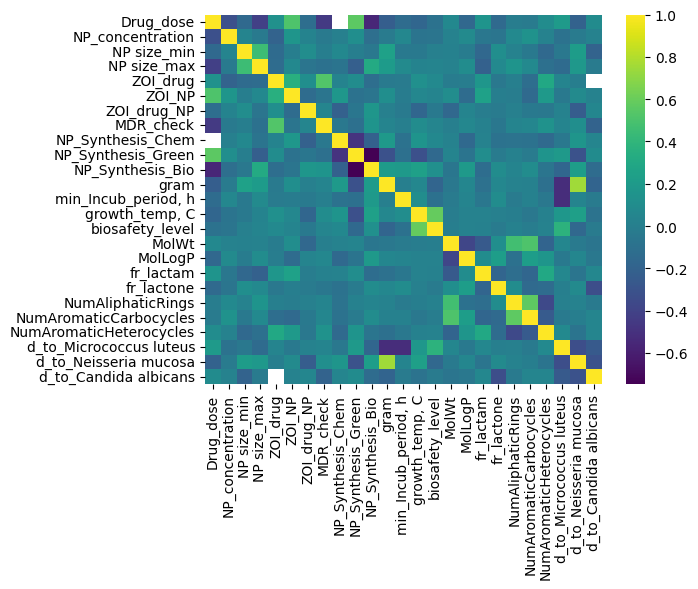

In [ ]:
# # Необходимо оставить только некоторые расстояния между бактериями - те, что меньшще всего коррелируют
def correlation(data, threshold=None):
    # https://github.com/anujdutt9/Feature-Selection-for-Machine-Learning/blob/master/Filter%20Methods/Correlation.ipynb
    # Set of all names of correlated columns
    col_corr = set()
    corr_mat = data.corr()
    for i in range(len(corr_mat.columns)):
        for j in range(i):
            if (abs(corr_mat.iloc[i,j]) > threshold):
                colname = corr_mat.columns[i]
                col_corr.add(colname)
    return col_corr

def remove_highly_correlated_features_from_df(df):
    # изначально только чтобы остачить только несколько расстояний между бактериями
    correlated_features = correlation(data=df, threshold=0.80)
    len(set(correlated_features))
    df = df[df.columns.drop(correlated_features)]
    return df

df = remove_highly_correlated_features_from_df(df)
print(df.shape)
sns.heatmap(df.corr(), cmap='viridis', yticklabels=True)


In [ ]:
# после вдумчивого визуального анализа графиков типа
# fig = px.density_contour(df, x="Drug", y="ZOI_drug", marginal_x="histogram", marginal_y="histogram", color='method')
# fig.show()
# получили, что надо обрезать данные так:

def remove_outlier ():
    df.drop(columns = ['ZOI_NP',
                       'isolated_from',
                       'MolWt',
                       'fr_lactone',
                       'NumAliphaticRings',
                       'NumAromaticCarbocycles',
                       'growth_temp, C',
                       'Bacteria',
                       'Drug',
                       'Drug_class_drug_bank',
                       'NP_Synthesis',
                       'Tax_id','genus','species'], inplace = True)
    df.drop(df[(df.ZOI_drug > 60)].index,inplace = True)
    #при анализе литературы было обнаружено, что составители данной БД вместо ZOI запихнули MIC, а значит в строках, в которых используется метод MIC данных про ZOI вообше нет
    #например, вот одна из статей https://doi.org/10.1371/journal.pone.0224904
    df.drop(df[(df.method == 'MIC') | (df.method == 'MBC')].index,inplace = True)
    df.drop(df[(df['NP size_min'] > 27)].index,inplace = True) #данных НЧ мало, так что они считались выбросами
    df.drop(df[(df['NP size_max'] > 60)].index,inplace = True) #данных НЧ мало, так что они считались выбросами
    df.replace('triangular', 'nanorods and triangles', inplace = True) #треугольников отдельно мало, было принято решение пихнуть вместе к стержням
    df.drop(columns =['method'], inplace = True)

remove_outlier()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 617 entries, 638 to 882
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Drug_dose                555 non-null    float64 
 1   NP_concentration         601 non-null    float64 
 2   NP size_min              617 non-null    float64 
 3   NP size_max              617 non-null    float64 
 4   shape                    617 non-null    category
 5   ZOI_drug                 451 non-null    float64 
 6   ZOI_drug_NP              451 non-null    float64 
 7   MDR_check                617 non-null    int64   
 8   NP_Synthesis_Chem        617 non-null    int64   
 9   NP_Synthesis_Green       617 non-null    int64   
 10  NP_Synthesis_Bio         617 non-null    float64 
 11  gram                     617 non-null    float64 
 12  min_Incub_period, h      617 non-null    float64 
 13  biosafety_level          617 non-null    int64   
 14  MolLogP 

In [ ]:
def last_preparation(df):
    df['shape']= df['shape'].map({'spherical' : 0,
                'nanorods and triangles' : 1
                })
    df["shape"] = df["shape"].astype(int)

last_preparation(df)


In [ ]:
#Наконец, заполняем пропуски датасета
def impute_data_knn(df):
    # удалить пропуски даргета
    df = df.drop(df[df.ZOI_drug_NP.isna()].index)



    scaler = MinMaxScaler()
    cols = df.columns
    scaler.fit(df.dropna())

    scaled_df = pd.DataFrame(scaler.transform(df), columns=cols)
    imputer = KNNImputer(weights='distance')
    imputed_scaled_df = pd.DataFrame(imputer.fit_transform(scaled_df), columns = cols)
    imputed_res = pd.DataFrame(scaler.inverse_transform(imputed_scaled_df), columns=cols)

    # imputed_res.to_csv("Imputed_data.csv")
    return imputed_res

In [ ]:
#заполняем пропуски
df = impute_data_knn(df)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Drug_dose                451 non-null    float64
 1   NP_concentration         451 non-null    float64
 2   NP size_min              451 non-null    float64
 3   NP size_max              451 non-null    float64
 4   shape                    451 non-null    float64
 5   ZOI_drug                 451 non-null    float64
 6   ZOI_drug_NP              451 non-null    float64
 7   MDR_check                451 non-null    float64
 8   NP_Synthesis_Chem        451 non-null    float64
 9   NP_Synthesis_Green       451 non-null    float64
 10  NP_Synthesis_Bio         451 non-null    float64
 11  gram                     451 non-null    float64
 12  min_Incub_period, h      451 non-null    float64
 13  biosafety_level          451 non-null    float64
 14  MolLogP                  4

# autoML

In [ ]:
#Для пробы сделали два разных AutoML

## PyCaret

In [ ]:
from pycaret.regression import *


exp1 = setup(
    df,
    target='ZOI_drug_NP', session_id = 4221,
    normalize = True,
    normalize_method = 'robust',
    polynomial_features = True,
    polynomial_degree = 2,
    )

,Description,Value
0,Session id,4221
1,Target,ZOI_drug_NP
2,Target type,Regression
3,Original data shape,"(451, 20)"
4,Transformed data shape,"(451, 210)"
5,Transformed train set shape,"(315, 210)"
6,Transformed test set shape,"(136, 210)"
7,Numeric features,19
8,Preprocess,True
9,Imputation type,simple


In [ ]:
best = exp1.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2.3382,13.4213,3.5205,0.7762,0.1763,0.1323,0.4930
br,Bayesian Ridge,2.3918,13.5615,3.5135,0.7665,0.2079,0.1447,0.1580
rf,Random Forest Regressor,2.3667,13.9498,3.6006,0.7581,0.1903,0.1402,0.6880
lightgbm,Light Gradient Boosting Machine,2.4804,14.5663,3.6627,0.7510,0.1944,0.1455,0.2240
ada,AdaBoost Regressor,2.9315,15.9442,3.8886,0.7315,0.2030,0.1751,0.2810
et,Extra Trees Regressor,2.3917,16.3476,3.8922,0.7170,0.2072,0.1441,0.6910
xgboost,Extreme Gradient Boosting,2.5571,16.6661,3.9609,0.7167,0.2058,0.1485,0.4620
en,Elastic Net,2.9570,16.4512,3.9531,0.7058,0.2090,0.1801,0.1740
llar,Lasso Least Angle Regression,3.0004,17.2326,4.0283,0.6942,0.2200,0.1895,0.2550
lasso,Lasso Regression,3.0274,17.4700,4.0607,0.6906,0.2222,0.1913,0.5070


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
#ПАРАМЕТРЫ лучшей модели - Gradient Boosting Regressor
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
model_gbr = exp1.create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.0396,7.1387,2.6718,0.7806,0.1662,0.1437
1,2.4325,11.6391,3.4116,0.8240,0.1690,0.1335
2,2.9198,18.7831,4.3339,0.7699,0.1900,0.1360
3,3.6915,36.8681,6.0719,0.6531,0.2049,0.1462
4,2.6006,15.0470,3.8791,0.8282,0.2201,0.1868
5,2.2667,11.9788,3.4610,0.7825,0.1775,0.1338
6,1.7959,6.1798,2.4859,0.8705,0.1336,0.1050
7,1.8977,7.3372,2.7087,0.9157,0.1404,0.1200
8,1.9263,7.9780,2.8245,0.8535,0.1523,0.1048


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
evaluate_model(model_gbr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
save_model(model_gbr,'model_gbr.pkl')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Drug_dose', 'NP_concentration',
                                              'NP size_min', 'NP size_max',
                                              'shape', 'ZOI_drug', 'MDR_check',
                                              'NP_Synthesis_Chem',
                                              'NP_Synthesis_Green',
                                              'NP_Synthesis_Bio', 'gram',
                                              'min_Incub_period, h',
                                              'biosafety_level', 'MolLogP',
                                              'fr_lactam',
                                              'NumAromaticHeterocycles',
                                              'd_...
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'

# LasyRegressor

## Загружаю библиотеки

## LazyPredict

При помощи библиотеки LazyPredict подбираем модель регрессии

In [ ]:


x = df.columns
target_name = 'ZOI_drug_NP'

X, y = df[x.drop(target_name)], df[target_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [ ]:
reg = LazyRegressor(predictions=True)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

100%|██████████| 42/42 [00:03<00:00, 11.55it/s]


In [ ]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.75,0.80,3.96,0.13
GradientBoostingRegressor,0.73,0.79,4.09,0.14
RandomForestRegressor,0.73,0.78,4.11,0.18
XGBRegressor,0.72,0.78,4.16,0.06
BaggingRegressor,0.71,0.77,4.20,0.03
LGBMRegressor,0.66,0.73,4.59,0.05
HistGradientBoostingRegressor,0.65,0.72,4.65,0.16
AdaBoostRegressor,0.65,0.72,4.66,0.07
Lars,0.63,0.71,4.76,0.03


Для модели с лучшими результатами R**2 и RMSE подбираем оптимальные параметры при помощи gridsearchCV

In [ ]:
def make_gridsearchCV(models_params: list, df: pd.DataFrame, test_size=0.25, cv=4, random_state=123, target_name='ZOI_drug_NP'):

    X, y = df[x.drop(target_name)], df[target_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    models = []

    for model in models_params:

        pipe = Pipeline([('scaler', MinMaxScaler()), ('model', model[0])])
        grid = GridSearchCV(pipe, model[1], scoring='r2', n_jobs=-1, cv=cv)
        grid.fit(X_train, y_train)

        print(f'--- Model: {pipe["model"].__class__.__name__} ---\n')
        print(f'Best params: {grid.best_params_}')
        print(f'Best CV R2 score: {grid.best_score_}')
        print(f'R2 score on unseen data: {r2_score(y_test, grid.best_estimator_.predict(X_test))}')

        models.append(grid.best_estimator_['model'])

    return models

In [ ]:
ex_tree = ExtraTreesRegressor(random_state=123, n_jobs=-1)
tree_params = {
    'model__max_depth': [10, 50, 100],
    'model__n_estimators': [50, 75, 100, 150],
    'model__criterion': ['squared_error', 'mean_squared_error'],
    'model__min_samples_split': [2, 3, 4],
    }
models_params = [[ex_tree, tree_params]]
models = make_gridsearchCV(models_params, df, cv=4)

--- Model: ExtraTreesRegressor ---

Best params: {'model__criterion': 'squared_error', 'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 150}
Best CV R2 score: 0.7877825178301994
R2 score on unseen data: 0.8032374633248075


In [ ]:
ex_tree = ExtraTreesRegressor(max_depth=10, min_samples_split=4, n_estimators=50, n_jobs=-1, random_state=123).fit(X_train, y_train)
print(f'R2 score on unseen data: {r2_score(y_test, ex_tree.predict(X_test))}')
print(f'RMSE score on unseen data: {(mean_squared_error(y_test, ex_tree.predict(X_test)))**0.5}')

R2 score on unseen data: 0.8238999956747757
RMSE score on unseen data: 3.706668597062864


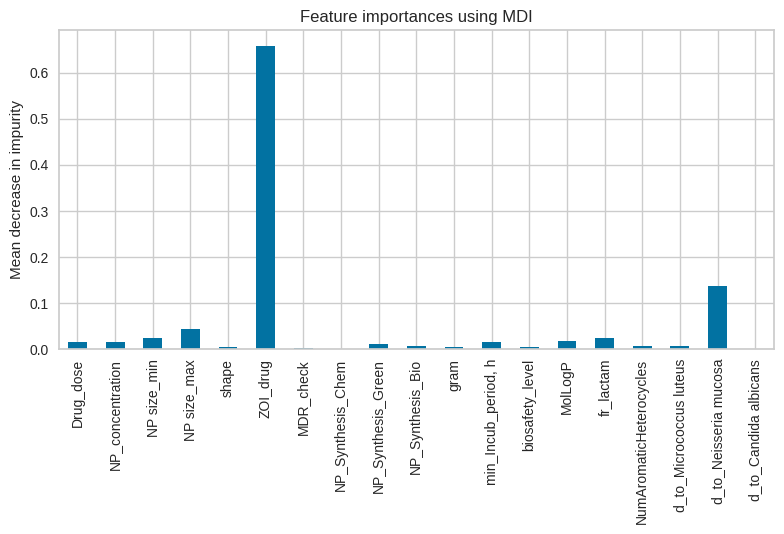

In [ ]:
importances = ex_tree.feature_importances_

ex_tree_importances = pd.Series(importances, index=x.drop(target_name))
std = np.std([ex_tree.feature_importances_ for tree in ex_tree.estimators_], axis=0)

fig, ax = plt.subplots()
ex_tree_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Обучаю модельку на полном датасете

In [ ]:
ex_tree = ExtraTreesRegressor(max_depth=10, min_samples_split=4, n_estimators=50, n_jobs=-1, random_state=123).fit(X, y)
print(f'R2 score on unseen data: {r2_score(y, ex_tree.predict(X))}')
print(f'RMSE score on unseen data: {(mean_squared_error(y, ex_tree.predict(X)))**0.5}')

R2 score on unseen data: 0.9603204442458724
RMSE score on unseen data: 1.6143039079476726


Сохроняю модельку

In [ ]:
# import pickle
filename = 'ExtraTreesRegressor.sav'
pickle.dump(ex_tree, open(filename, 'wb'))

# Нейронная сеть исходный код и нейронка работающая по весам

Epoch 1/700
12/12 [==============================] - 1s 17ms/step - loss: 396.0046 - val_loss: 370.0063
Epoch 2/700
12/12 [==============================] - 0s 5ms/step - loss: 356.2306 - val_loss: 323.5322
Epoch 3/700
12/12 [==============================] - 0s 5ms/step - loss: 298.7845 - val_loss: 255.4525
Epoch 4/700
12/12 [==============================] - 0s 3ms/step - loss: 217.9763 - val_loss: 171.8528
Epoch 5/700
12/12 [==============================] - 0s 4ms/step - loss: 130.8530 - val_loss: 104.7078
Epoch 6/700
12/12 [==============================] - 0s 4ms/step - loss: 77.8489 - val_loss: 92.9835
Epoch 7/700
12/12 [==============================] - 0s 4ms/step - loss: 72.0444 - val_loss: 91.9541
Epoch 8/700
12/12 [==============================] - 0s 3ms/step - loss: 68.8050 - val_loss: 85.0823
Epoch 9/700
12/12 [==============================] - 0s 3ms/step - loss: 66.2433 - val_loss: 81.4404
Epoch 10/700
12/12 [==============================] - 0s 4ms/step - loss: 64.532

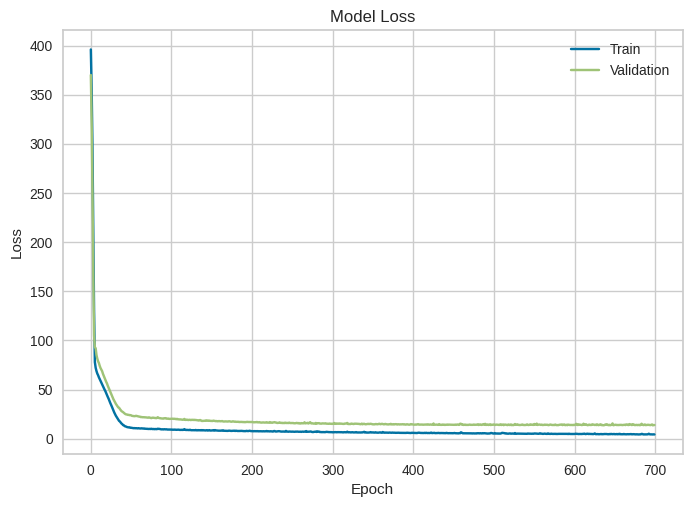

In [ ]:

# Загрузка данных
data = df

# Подготовка данных
X = data.drop(['ZOI_drug_NP'], axis=1).values
y = data['ZOI_drug_NP'].values

# Масштабирование признаков
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Создание модели нейронной сети
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Компиляция модели
model.compile(loss='mean_squared_error', optimizer='adam')

# Обучение модели
history = model.fit(X_train, y_train, epochs=700, batch_size=32, validation_data=(X_test, y_test))

# Оценка точности модели на тестовой выборке
loss = model.evaluate(X_test, y_test)
print(f'Loss: {loss}')

# Использование модели для предсказания значений
predictions = model.predict(X_test)

# Вывод предсказанных значений и соответствующих истинных значений
for i in range(len(predictions)):
    print(f'Predicted: {predictions[i]}, True: {y_test[i]}')

# Вычисление R2-score
r2 = r2_score(y_test, predictions)
print(f'R2-score: {r2}')

# Вычисление RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {rmse}')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
model.save_weights('model_weights.h5')

## А эта нейронка кушает веса вместо обучения

In [ ]:
# Загрузка данных из файла CSV
data = df

# Подготовка данных
X = data.drop(['ZOI_drug_NP'], axis=1).values
y = data['ZOI_drug_NP'].values

# Масштабирование признаков
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Создание новой модели с такой же архитектурой
new_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Загрузка сохраненных весов
new_model.load_weights('model_weights.h5')

# Компиляция модели
new_model.compile(loss='mean_squared_error', optimizer='adam')

# Теперь можно использовать новую модель для предсказания значений
new_predictions = new_model.predict(X_test)

# Оценка точности модели на тестовой выборке
loss = new_model.evaluate(X_test, y_test)
print(f'Loss: {loss}')

# Использование модели для предсказания значений
predictions = new_model.predict(X_test)

# Вывод предсказанных значений и соответствующих истинных значений
for i in range(len(predictions)):
    print(f'Predicted: {predictions[i]}, True: {y_test[i]}')

# Вычисление R2-score
r2 = r2_score(y_test, predictions)
print(f'R2-score: {r2}')

# Вычисление RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {rmse}')


3/3 [==============================] - 0s 5ms/step - loss: 13.8457
Loss: 13.845684051513672
3/3 [==============================] - 0s 3ms/step
Predicted: [17.458275], True: 15.0
Predicted: [29.184471], True: 32.0
Predicted: [11.176393], True: 13.0
Predicted: [11.491494], True: 10.0
Predicted: [17.878057], True: 20.0
Predicted: [20.353416], True: 19.0
Predicted: [18.935173], True: 20.0
Predicted: [25.244123], True: 24.0
Predicted: [9.076443], True: 10.0
Predicted: [30.000975], True: 34.00000000000001
Predicted: [30.525951], True: 26.0
Predicted: [19.621359], True: 16.0
Predicted: [22.91909], True: 22.0
Predicted: [14.304628], True: 13.0
Predicted: [12.414443], True: 12.0
Predicted: [26.679348], True: 28.000000000000004
Predicted: [25.657505], True: 20.0
Predicted: [13.432115], True: 13.0
Predicted: [17.899332], True: 15.0
Predicted: [26.739834], True: 25.000000000000004
Predicted: [10.430043], True: 25.000000000000004
Predicted: [21.18845], True: 22.0
Predicted: [10.45237], True: 16.0
P